# ¿Cuál fue la recepción de CHAT-GPT en Twitter? : análisis de sentimientos

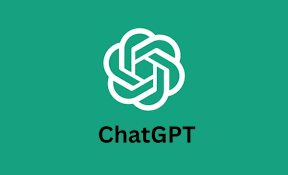


Este código presenta el análisis de sentimientos de 1000 twits recolectados entre el 24 y 25 de febrero de 2023 de usuarios localizados entre México y Perú que expresaron sus opiniones sobre ChatGpt. 
Se seleccionó el modelo de regresión logística que fue entrenado con un DataSet de huggingface. 


In [9]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import silhouette_score

En esta línea cargamos los dataSets de huggingFace 

In [25]:
!pip install datasets

     -------------------------------------- 469.0/469.0 kB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 77.1/77.1 kB 4.2 MB/s eta 0:00:00
     -------------------------------------- 115.7/115.7 kB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 190.3/190.3 kB ? eta 0:00:00
     ---------------------------------------- 110.5/110.5 kB ? eta 0:00:00
     ---------------------------------------- 143.0/143.0 kB ? eta 0:00:00
     ------------------------------------- 322.2/322.2 kB 20.8 MB/s eta 0:00:00
     --------------------------------------- 20.6/20.6 MB 19.8 MB/s eta 0:00:00
     ---------------------------------------- 56.4/56.4 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 94.0/94.0 kB ? eta 0:00:00
     ---------------------------------------- 42.7/42.7 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 128.0/128.0 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installatio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from datasets import load_dataset

dataset = load_dataset("mrm8488/sst2-es-mt")

Found cached dataset parquet (C:/Users/villa/.cache/huggingface/datasets/mrm8488___parquet/mrm8488--sst2-es-mt-474f263f32c1dac8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [61]:
dataset 

DatasetDict({
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'sentence_es'],
        num_rows: 1821
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'sentence_es'],
        num_rows: 872
    })
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'sentence_es'],
        num_rows: 67349
    })
})

En esta línea seleccionamos el conjunto de datos Test

In [62]:
datos = load_dataset( "mrm8488/sst2-es-mt" ,split= 'train' )


Found cached dataset parquet (C:/Users/villa/.cache/huggingface/datasets/mrm8488___parquet/mrm8488--sst2-es-mt-474f263f32c1dac8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [63]:
datos

Dataset({
    features: ['sentence', 'label', 'idx', 'sentence_es'],
    num_rows: 67349
})

Realicé este paso porqué no sé navegar en el directorio

In [65]:
datos.to_csv("dataTrain.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

8431502

En esta línea cargo mi dataSet de Entrenamiento

In [66]:
path = 'dataTrain.csv'
data = pd.read_csv(path)
data.head()

,sentence,label,idx,sentence_es
0,hide new secretions from the parental units,0,0,ocultar nuevas secreciones de las unidades par...
1,"contains no wit , only labored gags",0,1,"no contiene ingenio, sólo mordazas laboriosas"
2,that loves its characters and communicates som...,1,2,que ama a sus personajes y comunica algo basta...
3,remains utterly satisfied to remain the same t...,0,3,sigue totalmente satisfecho de seguir siendo e...
4,on the worst revenge-of-the-nerds clichés the ...,0,4,en los peores clichés de venganza de los nervi...


### Clasificación de Datos en Train y Test

En las siguientes líneas de código se dividen los datos en entrenamiento y testeo, luego se inicializa el modelo seleccionado (regresión logística)

In [68]:
data.label.value_counts()

1    37569
0    29780
Name: label, dtype: int64

In [69]:
data.sentence_es.value_counts(normalize=True) 

Muy bien.                                                                        0.000148
Muy gracioso.                                                                    0.000134
¡Qué horror!                                                                     0.000134
No tiene sentido.                                                                0.000104
¡Qué vergüenza!                                                                  0.000104
                                                                                   ...   
cualquier película de John Waters la tiene derrotada por una milla de campo.     0.000015
un documental nítido y rápido                                                    0.000015
humor negro hilarantemente malvado...                                            0.000015
tiene un montón de risas                                                         0.000015
lúgubre y lenta                                                                  0.000015
Name: sent

In [70]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=50)

print(f"El cojunto de datos de entrenamiento tiene {train.shape[0]} registros")
print(f"El cojunto de datos de prueba tiene {test.shape[0]} registros")

El cojunto de datos de entrenamiento tiene 53879 registros
El cojunto de datos de prueba tiene 13470 registros


In [71]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf_vect


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function pre_procesado at 0x000001A6F6C20798>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [72]:
X_train = tfidf_vect.fit_transform(train.sentence_es.values)
y_train = train.label.values

X_test = tfidf_vect.transform(test.sentence_es.values)
y_test = test.label.values

#para verificar, lo transoformamos a matriz
X_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
#o Hacemos la prueba con nuestra y para verifciar el etiquetado
y_train

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

### Entrenamiento del modelo

In [74]:
data

,sentence,label,idx,sentence_es
0,hide new secretions from the parental units,0,0,ocultar nuevas secreciones de las unidades par...
1,"contains no wit , only labored gags",0,1,"no contiene ingenio, sólo mordazas laboriosas"
2,that loves its characters and communicates som...,1,2,que ama a sus personajes y comunica algo basta...
3,remains utterly satisfied to remain the same t...,0,3,sigue totalmente satisfecho de seguir siendo e...
4,on the worst revenge-of-the-nerds clichés the ...,0,4,en los peores clichés de venganza de los nervi...
...,...,...,...,...
67344,a delightful comedy,1,67344,una comedia encantadora
67345,"anguish , anger and frustration",0,67345,"angustia, ira y frustración"
67346,"at achieving the modest , crowd-pleasing goals...",1,67346,"al logro de los objetivos modestos, agradables..."
67347,a patient viewer,1,67347,un visor de pacientes


In [75]:
#Inicializamos los clasificadores
logreg = LogisticRegression(class_weight='balanced')

In [76]:
#Entrenamos el modelo
modelo1= logreg.fit(X_train, y_train)
modelo1

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Métricas de evaluación

In [77]:
# Hacemos las predicciones para los datos de prueba (test)
y_pred_lr = logreg.predict(X_test)
y_pred_lr

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [78]:
print("Regresión Logística")
print(classification_report(y_test, y_pred_lr))
print()

Regresión Logística
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5875
           1       0.89      0.87      0.88      7595

    accuracy                           0.87     13470
   macro avg       0.86      0.87      0.86     13470
weighted avg       0.87      0.87      0.87     13470




Text(0.5, 1.0, 'Regresión Logística')

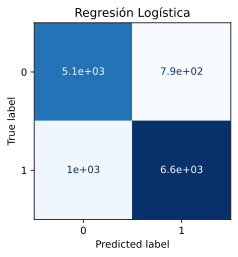

In [79]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(15,15))

ax2 = fig.add_subplot(1,3,2)
plot_confusion_matrix(logreg, X_test, y_test, cmap = 'Blues', ax=ax2).im_.colorbar.remove()
plt.title("Regresión Logística")

### Cargamos y preprocesamos nuestros datos

In [80]:
import pandas as pd
data=pd.read_csv('dataGPT.csv')
data2=data
data2.sample (10)

,tweet,date,user_location,coordinates,link
837,Me cierran chatgpt y me salgo de la carrera,2023-02-24 02:45:51,"Cali, Colombia",NaN,https://twitter.com/i/web/status/1628949295427...
915,ChatGPT para redactores: amenaza vs. oportunid...,2023-02-23 23:41:37,Venezuela,NaN,https://twitter.com/i/web/status/1628902934464...
76,ChatGPT es una maravilla,2023-02-25 17:20:14,"Cartagena, Colombia",NaN,https://twitter.com/i/web/status/1629531732197...
563,#ChatGPT se convierte en una 'aliada' para pub...,2023-02-24 17:13:12,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629167574951...
652,"@Angariel79 @petrogustavo Acá el Bot es usted,...",2023-02-24 14:55:54,Bogotá,NaN,https://twitter.com/i/web/status/1629133019922...
724,Veinte peligros que la IA – ChatGPT representa...,2023-02-24 11:46:36,Dominican Republic,NaN,https://twitter.com/i/web/status/1629085381818...
496,Google llega tarde a competir con ChatGPT... p...,2023-02-24 18:54:38,Lima,NaN,https://twitter.com/i/web/status/1629193097543...
25,¿No se sienten mal al no darle las gracias a C...,2023-02-25 19:29:25,México,NaN,https://twitter.com/i/web/status/1629564240926...
740,@armandoextremo @morales0606 @eltemaguillev ¿Q...,2023-02-24 10:58:10,Mexico City,NaN,https://twitter.com/i/web/status/1629073194228...
665,Lo que más ansiedad le genera a un #trabajador...,2023-02-24 14:20:32,Bogota,NaN,https://twitter.com/i/web/status/1629124119022...


In [81]:
import re 
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweet']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text, links, hashtags, mentions

In [82]:
data2[['clean', 'links', 'hashtags', 'mentions']] = data2.apply(text_clean, axis=1, result_type='expand')

data2.head(10)


,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[]
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",NaN,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[]
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,NaN,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[]
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",NaN,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[]
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",NaN,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow]
5,@elkinmartinez6 @5eniorDeveloper Nada de lo qu...,2023-02-25 20:39:00,Hermosillo sonora,NaN,https://twitter.com/i/web/status/1629581751524...,Nada de lo que sea programación enfocada en ...,[],[],"[@elkinmartinez6, @5eniorDeveloper]"
6,"Google Bard: qué es, cómo funciona y qué puede...",2023-02-25 20:35:01,guayaquil,NaN,https://twitter.com/i/web/status/1629580749476...,"Google Bard: qué es, cómo funciona y qué puede...",[https://t.co/YbgVPQrxUP],[],[@xatakamexico]
7,Las empresas se encuentran en continuo cambio ...,2023-02-25 20:31:49,Colombia,NaN,https://twitter.com/i/web/status/1629579945864...,Las empresas se encuentran en continuo cambio ...,[],[],[]
8,#OJO Nuevo malware roba credenciales de redes ...,2023-02-25 20:30:00,Ciudad de México,NaN,https://twitter.com/i/web/status/1629579485824...,Nuevo malware roba credenciales de redes soci...,"[https://t.co/F1bhwIJ1L0, https://t.co/IKW9a2i...",[#OJO],[]
9,¿Has probado #ChatGPT ?: otras cinco 'apps' de...,2023-02-25 20:24:34,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629578118775...,¿Has probado ?: otras cinco 'apps' de intelig...,[https://t.co/nnufzyHP37],[#ChatGPT],[]


In [83]:
import regex
import emoji
 
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
 
    return emoji_list
 
data2['emojis'] = data2['clean'].apply(lambda text: get_emojis(text))
data2.head(10);

In [84]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [85]:
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

In [86]:
data2['preproces'] = data2['clean'].apply(lambda texto: pre_procesado(texto))
data2.head(10)

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,preproces
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],inesperado milagro crece rápido cuenta cientos...
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",NaN,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],batalla bots transformará forma personas encue...
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,NaN,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],llama nuevo modelo lenguaje inteligencia artif...
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",NaN,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],increíble interesante
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",NaN,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",ambas herramientas ofrecen respuestas pregunta...
5,@elkinmartinez6 @5eniorDeveloper Nada de lo qu...,2023-02-25 20:39:00,Hermosillo sonora,NaN,https://twitter.com/i/web/status/1629581751524...,Nada de lo que sea programación enfocada en ...,[],[],"[@elkinmartinez6, @5eniorDeveloper]",[],programación enfocada demostrar conceptos mate...
6,"Google Bard: qué es, cómo funciona y qué puede...",2023-02-25 20:35:01,guayaquil,NaN,https://twitter.com/i/web/status/1629580749476...,"Google Bard: qué es, cómo funciona y qué puede...",[https://t.co/YbgVPQrxUP],[],[@xatakamexico],[],google bard cómo funciona puedes hacer intelig...
7,Las empresas se encuentran en continuo cambio ...,2023-02-25 20:31:49,Colombia,NaN,https://twitter.com/i/web/status/1629579945864...,Las empresas se encuentran en continuo cambio ...,[],[],[],[],empresas encuentran continuo cambio debido tra...
8,#OJO Nuevo malware roba credenciales de redes ...,2023-02-25 20:30:00,Ciudad de México,NaN,https://twitter.com/i/web/status/1629579485824...,Nuevo malware roba credenciales de redes soci...,"[https://t.co/F1bhwIJ1L0, https://t.co/IKW9a2i...",[#OJO],[],[],nuevo malware roba credenciales redes sociales...
9,¿Has probado #ChatGPT ?: otras cinco 'apps' de...,2023-02-25 20:24:34,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629578118775...,¿Has probado ?: otras cinco 'apps' de intelig...,[https://t.co/nnufzyHP37],[#ChatGPT],[],[],probado cinco apps inteligencia artificial sor...


In [87]:
nuevos = data2['preproces'].tolist()
nuevos_trans = tfidf_vect.transform(nuevos)

In [105]:
lista= modelo1.predict(nuevos_trans).tolist()
lista

[1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,


In [119]:
data2['sentimiento']=lista

data2

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,preproces,sentimiento
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],inesperado milagro crece rápido cuenta cientos...,1
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",NaN,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],batalla bots transformará forma personas encue...,1
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,NaN,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],llama nuevo modelo lenguaje inteligencia artif...,1
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",NaN,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],increíble interesante,1
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",NaN,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",ambas herramientas ofrecen respuestas pregunta...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,2023-02-23 21:00:06,Venezuela,NaN,https://twitter.com/i/web/status/1628862286558...,Baidu lanza Ernie Bot para competir con ChatGPT,[https://t.co/ic8XrEOeR0],[],[],[],baidu lanza ernie bot competir chatgpt,0
996,¿Te imaginaste que un juez realice una audienc...,2023-02-23 20:57:36,"Lima, Peru",NaN,https://twitter.com/i/web/status/1628861658285...,¿Te imaginaste que un juez realice una audienc...,[https://t.co/oNfUuwEhG8],[],[],[🤖],imaginaste juez realice audiencia metaverso us...,0
997,Microsoft incluye publicidad en las respuestas...,2023-02-23 20:57:01,Ciudad de México,NaN,https://twitter.com/i/web/status/1628861509559...,Microsoft incluye publicidad en las respuestas...,[https://t.co/ZbrhqHKALK],[#Tecnología],[@Mkt4eCommerceMX],[],microsoft incluye publicidad respuestas creada...,1
998,Lo que ustedes no saben es que los tuits de la...,2023-02-23 20:53:56,"Cali, Colombia",NaN,https://twitter.com/i/web/status/1628860734229...,Lo que ustedes no saben es que los tuits de la...,[],[],[],[🙏🏻],ustedes saben tuits maluca carolina sanín escr...,1


In [122]:
data3=data2[['tweet', 'user_location', 'preproces', 'sentimiento']]
data3

,tweet,user_location,preproces,sentimiento
0,El inesperado milagro de #ChatGPT: crece más r...,"Starbucks, clouds y Chimbote",inesperado milagro crece rápido cuenta cientos...,1
1,La batalla de los bots transformará la forma c...,"Miami, FL",batalla bots transformará forma personas encue...,1
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",Santa Cruz de la Sierra,llama nuevo modelo lenguaje inteligencia artif...,1
3,Qué increíble e interesante es el #ChatGPT 🤯,"San José, Costa Rica",increíble interesante,1
4,💻 Ambas herramientas ofrecen respuestas a preg...,"Mazatlán, Sinaloa",ambas herramientas ofrecen respuestas pregunta...,1
...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,Venezuela,baidu lanza ernie bot competir chatgpt,0
996,¿Te imaginaste que un juez realice una audienc...,"Lima, Peru",imaginaste juez realice audiencia metaverso us...,0
997,Microsoft incluye publicidad en las respuestas...,Ciudad de México,microsoft incluye publicidad respuestas creada...,1
998,Lo que ustedes no saben es que los tuits de la...,"Cali, Colombia",ustedes saben tuits maluca carolina sanín escr...,1


In [139]:
freq = data3.groupby(['sentimiento']).count() 
print(freq)

             tweet  user_location  preproces
sentimiento                                 
0              567            564        567
1              433            432        433
